### Plotting supply and demand ###

Using data from Drax Electric Insights, this script plots the supply and demand of electricity in the UK.

In [1]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt

In [2]:
# Set up the path to the data
price_data_path = Path("/home/users/benhutch/energy-sotcr-2024-2025/price_data/GB electricity data 2024-25.xlsx")

# Load the data from the Excel file
price_data = pd.read_excel(price_data_path, header=2)

In [3]:
price_data.head()

,Date,Time,Nuclear,Biomass,Imports,Hydro,Wind,Solar,Gas,Coal,...,Gross Exports,Demand (MW),Demand Net (MW),Fossil (MW),Carbon (tCO₂/hr),Carbon (g/kWh),Day Ahead,Realtime,Balancing,Temper-ature (°C)
0,2024-04-01,00:00:00,4287.0,2207.0,1430.0,251.0,10287.0,0,3798.0,261,...,-1218,22521.0,12234.0,4059.0,1898.986276,84.320691,27.54,25.050000,17.3313,9.6
1,2024-04-01,00:30:00,4305.0,2288.0,1151.0,274.0,9893.0,0,3728.0,259,...,-1287,21898.0,12005.0,3987.0,1854.829413,84.703142,26.46,25.650000,17.1431,9.6
2,2024-04-01,01:00:00,4305.0,2285.0,1586.0,274.0,9529.0,0,3566.0,259,...,-963,21804.0,12275.0,3825.0,1963.548171,90.054493,25.19,23.990000,17.4830,9.6
3,2024-04-01,01:30:00,4314.0,2288.0,1986.0,256.0,9524.0,0,3539.0,259,...,-995,22166.0,12642.0,3798.0,1952.015631,88.063504,33.60,76.000000,19.6611,9.6
4,2024-04-01,02:00:00,4312.0,2289.0,1252.0,255.0,10066.0,0,3534.0,261,...,-1176,21969.0,11903.0,3795.0,1846.288993,84.040648,47.54,73.384327,19.2696,9.6


In [4]:
# Convert the 'Date' column to datetime format
price_data['Date'] = pd.to_datetime(price_data['Date'])
# Convert the 'Time' column to datetime format
price_data['Time'] = pd.to_datetime(price_data['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
price_data['Datetime'] = pd.to_datetime(price_data['Date'].astype(str) + ' ' + price_data['Time'].astype(str))

# Set the 'Datetime' column as the index
price_data.set_index('Datetime', inplace=True)

# drop the 'Date' and 'Time' columns as they are no longer needed
price_data.drop(columns=['Date', 'Time'], inplace=True)

In [5]:
# Aggregate the data to daily frequency, taking the means
price_data_daily = price_data.resample('D').mean()

# take a rolling mean over 5 days
price_data_daily_smoothed = price_data_daily.rolling(window=5, center=True, min_periods=1).mean()

In [11]:
# convert demand to GW
price_data_daily_smoothed['Demand (GW)'] = price_data_daily_smoothed['Demand (MW)'] / 1000
# Convert wind and solar generation to GW
price_data_daily_smoothed['Wind (GW)'] = price_data_daily_smoothed['Wind'] / 1000
price_data_daily_smoothed['Solar (GW)'] = price_data_daily_smoothed['Solar'] / 1000

In [13]:
# remove the name for the index
price_data_daily_smoothed.index.name = None

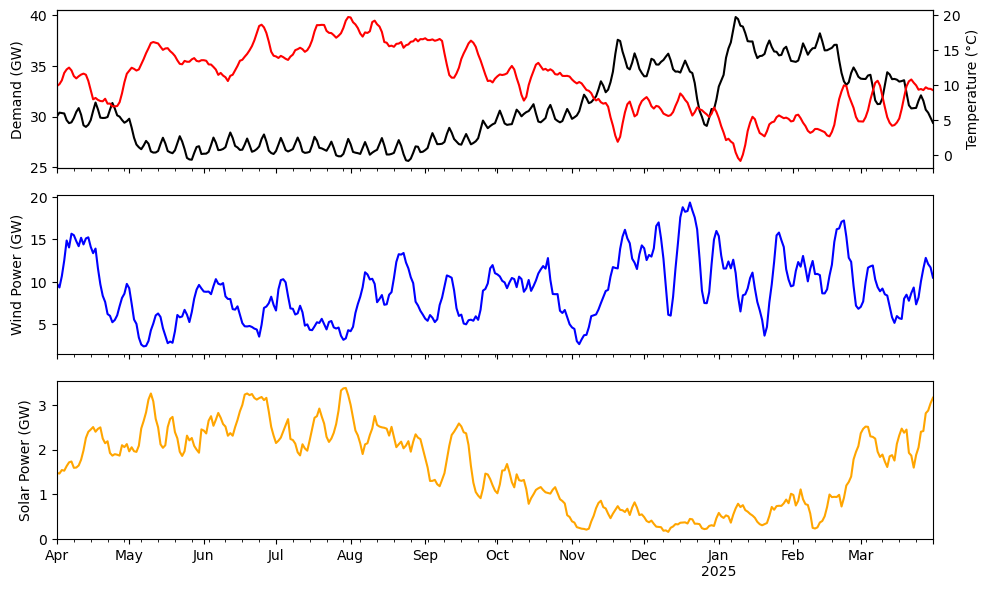

In [20]:
# Set up a figure with 3 rows and 1 column, shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Set up the axes
ax1 = axs[0]
ax1_b = axs[0].twinx()
ax2 = axs[1]
ax3 = axs[2]

# Plot the demand column
price_data_daily_smoothed['Demand (GW)'].plot(ax=ax1, color='k', label='Demand')

# Plot the temperature in red on the first subplot
price_data_daily_smoothed['Temper-ature (°C)'].plot(ax=ax1_b, color='red', label='Temperature')

# Set the labels and title for the first subplot
ax1.set_ylabel('Demand (GW)')
ax1_b.set_ylabel('Temperature (°C)')

# Plot the wind power generation
price_data_daily_smoothed['Wind (GW)'].plot(ax=ax2, color='blue', label='Wind Power')

# Set the labels
ax2.set_ylabel('Wind Power (GW)')

# Plot the solar power generation
price_data_daily_smoothed['Solar (GW)'].plot(ax=ax3, color='orange', label='Solar Power')

# Set the labels
ax3.set_ylabel('Solar Power (GW)')

# enforce a tight layout
plt.tight_layout()

In [21]:
# Now quantify demand net renewbles
price_data_daily_smoothed['Demand Net Renewables (GW)'] = (
    price_data_daily_smoothed['Demand (GW)'] - 
    (price_data_daily_smoothed['Wind (GW)'] + 
    price_data_daily_smoothed['Solar (GW)'])
)

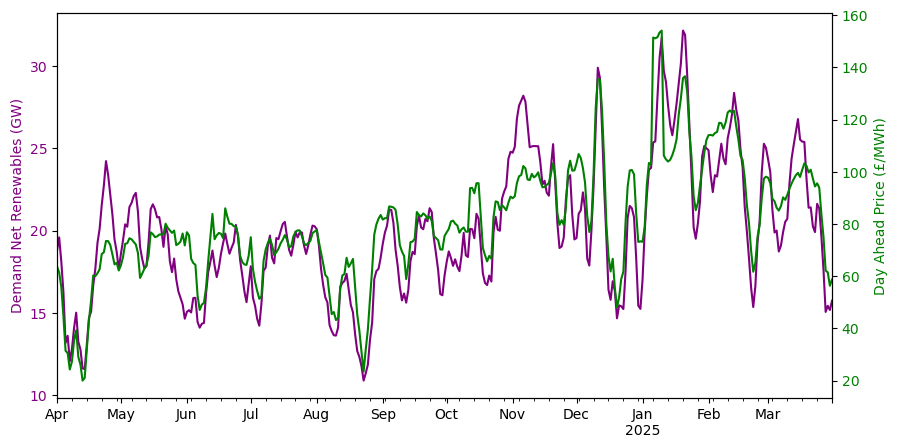

In [28]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the demand net renewables
price_data_daily_smoothed['Demand Net Renewables (GW)'].plot(ax=ax, color='purple', label='Demand Net Renewables')

# Set the labels and title
ax.set_ylabel('Demand Net Renewables (GW)', color='purple')

# Duplicate the x-axis for the date
ax2 = ax.twinx()

# Plot Day ahead prices on the secondary x-axis
price_data_daily_smoothed['Day Ahead'].plot(ax=ax2, color='green', label='Day Ahead Price')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Day Ahead Price (£/MWh)', color='green')

# set the ticks the same color as the line being plotted
ax2.tick_params(axis='y', labelcolor='green')
ax.tick_params(axis='y', labelcolor='purple')

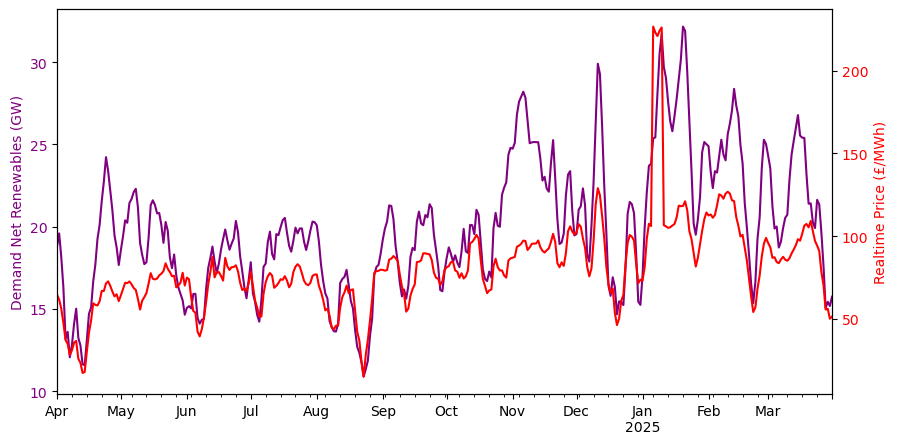

In [29]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the demand net renewables
price_data_daily_smoothed['Demand Net Renewables (GW)'].plot(ax=ax, color='purple', label='Demand Net Renewables')

# Set the labels and title
ax.set_ylabel('Demand Net Renewables (GW)', color='purple')

# Duplicate the x-axis for the date
ax2 = ax.twinx()

# Plot Day ahead prices on the secondary x-axis
price_data_daily_smoothed['Realtime'].plot(ax=ax2, color='red', label='Day Ahead Price')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Realtime Price (£/MWh)', color='red')

# set the ticks the same color as the line being plotted
ax2.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='y', labelcolor='purple')

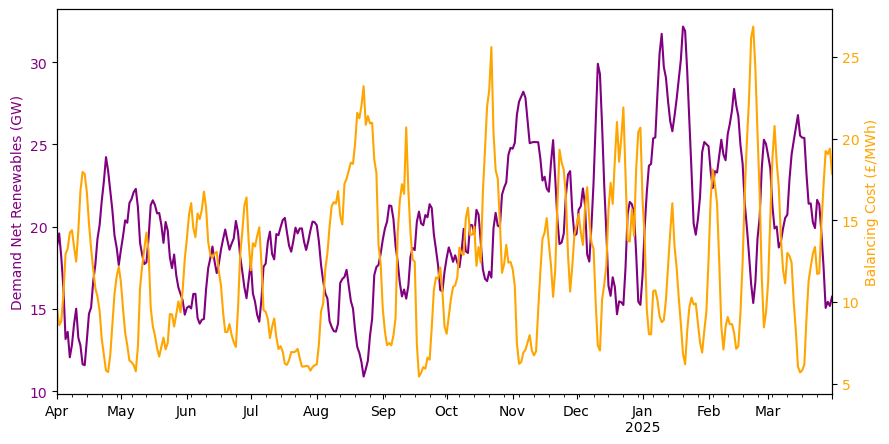

In [30]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the demand net renewables
price_data_daily_smoothed['Demand Net Renewables (GW)'].plot(ax=ax, color='purple', label='Demand Net Renewables')

# Set the labels and title
ax.set_ylabel('Demand Net Renewables (GW)', color='purple')

# Duplicate the x-axis for the date
ax2 = ax.twinx()

# Plot Day ahead prices on the secondary x-axis
price_data_daily_smoothed['Balancing'].plot(ax=ax2, color='orange', label='Day Ahead Price')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Balancing Cost (£/MWh)', color='orange')

# set the ticks the same color as the line being plotted
ax2.tick_params(axis='y', labelcolor='orange')
ax.tick_params(axis='y', labelcolor='purple')

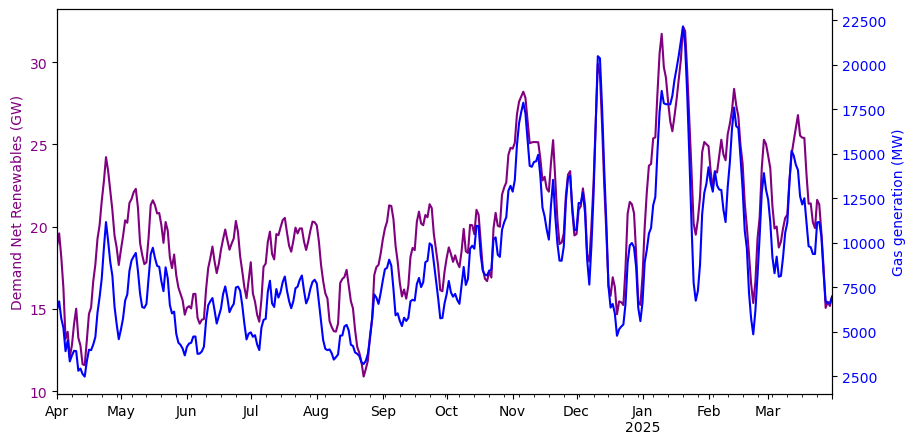

In [37]:
# Set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the demand net renewables
price_data_daily_smoothed['Demand Net Renewables (GW)'].plot(ax=ax, color='purple', label='Demand Net Renewables')

# Set the labels and title
ax.set_ylabel('Demand Net Renewables (GW)', color='purple')

# Duplicate the x-axis for the date
ax2 = ax.twinx()

# Plot Day ahead prices on the secondary x-axis
price_data_daily_smoothed['Gas'].plot(ax=ax2, color='blue', label='Gross Imports')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Gas generation (MW)', color='blue')

# set the ticks the same color as the line being plotted
ax2.tick_params(axis='y', labelcolor='blue')
ax.tick_params(axis='y', labelcolor='purple')

In [33]:
# Convert gross imports to GW
price_data_daily_smoothed['Gross Imports (GW)'] = price_data_daily_smoothed['Gross Imports'] / 1000

# Set up Demand Net Renewables Net Imports
price_data_daily_smoothed['Demand Net Renewables Net Imports (GW)'] = (
    price_data_daily_smoothed['Demand Net Renewables (GW)'] - 
    price_data_daily_smoothed['Gross Imports (GW)']
)

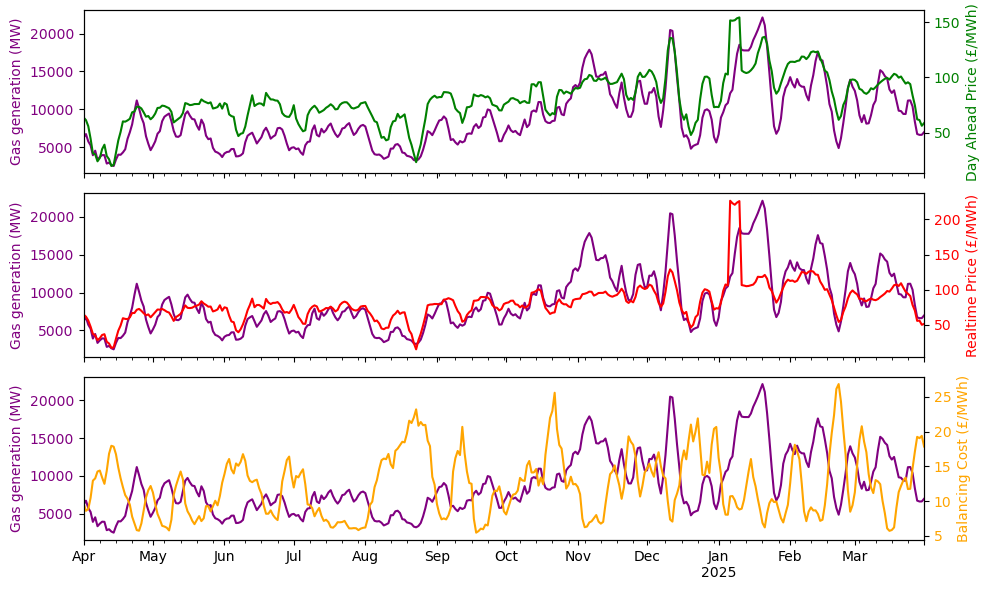

In [36]:
# Set up a figure with three rows and one column, shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Set up the axes
ax1 = axs[0] ; ax1_b = axs[0].twinx()
ax2 = axs[1] ; ax2_b = axs[1].twinx()
ax3 = axs[2] ; ax3_b = axs[2].twinx()

# Plot the demand net renewables net imports
price_data_daily_smoothed['Gas'].plot(ax=ax1, color='purple', label='Demand Net Renewables Net Imports')

# Plot the day ahead prices in green
price_data_daily_smoothed['Day Ahead'].plot(ax=ax1_b, color='green', label='Day Ahead Price')

# Set the labels and title for the first subplot
ax1.set_ylabel('Gas generation (MW)', color='purple')
ax1_b.set_ylabel('Day Ahead Price (£/MWh)', color='green')
# set the ticks the same color as the line being plotted
ax1_b.tick_params(axis='y', labelcolor='green')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot the demand net renewables net imports on the second subplot
price_data_daily_smoothed['Gas'].plot(ax=ax2, color='purple', label='Demand Net Renewables Net Imports')
# Plot the realtime prices in red
price_data_daily_smoothed['Realtime'].plot(ax=ax2_b, color='red', label='Realtime Price')

# Set the labels for the second subplot
ax2.set_ylabel('Gas generation (MW)', color='purple')
ax2_b.set_ylabel('Realtime Price (£/MWh)', color='red')
# set the ticks the same color as the line being plotted
ax2_b.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='purple')

# Plot the demand net renewables net imports on the third subplot
price_data_daily_smoothed['Gas'].plot(ax=ax3, color='purple', label='Demand Net Renewables Net Imports')
# Plot the balancing costs in orange
price_data_daily_smoothed['Balancing'].plot(ax=ax3_b, color='orange', label='Balancing Cost')

# Set the labels for the third subplot
ax3.set_ylabel('Gas generation (MW)', color='purple')
ax3_b.set_ylabel('Balancing Cost (£/MWh)', color='orange')
# set the ticks the same color as the line being plotted
ax3_b.tick_params(axis='y', labelcolor='orange')
ax3.tick_params(axis='y', labelcolor='purple')

# enforce a tight layout
plt.tight_layout()